### Data Loading and Label Mapping

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import csv
import os
import time
from random import uniform, choice
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from googlesearch import search


c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_csv('Test_dataset(FINAL).csv')
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,NASA’s Perseverance rover finds its first poss...,sciencenews.org,"""Has NASA's Perseverance rover discovered evid...","""Has NASA officially announced the discovery o...",True
1,Sepsis tests take days putting patients at ri...,sciencenews.org,"""What is the current average wait time for sep...","""Is there a recent study or research that show...",True
2,Nasa's DART asteroid unlocks complex history o...,https://timesofindia.indiatimes.com/,"""What is the history of NASA's DART mission an...","""Has NASA's DART mission provided evidence of ...",True
3,Say goodbye to back pain patients go for adva...,https://timesofindia.indiatimes.com/,"""What are the benefits of advanced endoscopy s...","""Has 'advanced endoscopy spine surgery for sci...",True
4,Neurodivergent children more likely to develop...,https://timesofindia.indiatimes.com/,"""What does the study find about the likelihood...","""Is there a peer-reviewed study titled 'Neurod...",True
...,...,...,...,...,...
683,"""Google's parent company faces UK investigatio...",Synthetically Generated,"""Has Google's parent company been investigated...","""Has Alphabet Inc., Google's parent company, b...",False
684,"""Intel announces hiring spree to fund recovery...",Synthetically Generated,"""What is the current hiring status of Intel as...","""Has Intel announced a hiring spree to fund re...",False
685,"""Ola Electric IPO grey market premium skyrocke...",Synthetically Generated,"""What is the current grey market premium for O...","""Has the Ola Electric IPO grey market premium ...",False
686,"""Japan's Nikkei 225 Index Soars 12.4%, Its Big...",Synthetically Generated,"""What was the percentage increase in Japan's N...","1. ""Is there a news article from a reliable so...",False


In [3]:
df['Label'].value_counts()

Label
True     344
False    344
Name: count, dtype: int64

<Axes: ylabel='Label'>

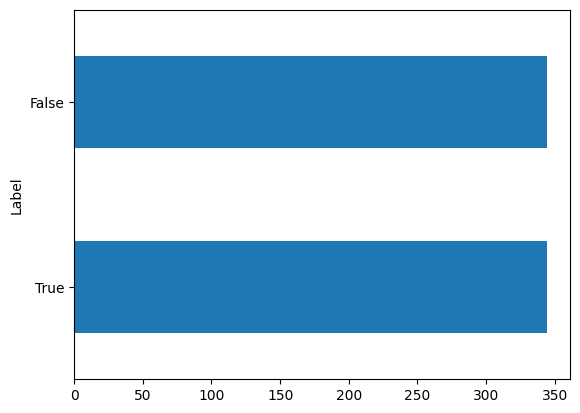

In [4]:
df['Label'].value_counts().plot(kind='barh')

### Articles Pipeline

In [5]:
def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []
    if search_query_results:
        for results in search_query_results:
            try:
                # Send a request to the URL and get the HTML content
                response = requests.get(results)
                soup = BeautifulSoup(response.content, 'lxml')

                currentp = ""
                # Scrape <p> tags
                p_tags = soup.find_all('p')
                for p in p_tags:
                    currentp += p.text
                article_content.append(currentp)

                currenth1 = ""
                # Scrape <h1> tags
                h1_tags = soup.find_all('h1')
                for h1 in h1_tags:
                    currenth1 += h1.text

                article_titles.append(currenth1)

            except Exception as e:
                print(f"An error occurred: {e}")
    return article_titles, article_content


# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

In [6]:
#To scrape headlines for the FactCC endpoint
def dataframegen(text_input):
    scraped_df = make_data(text_input)
    scraped_df.dropna(inplace=True)
    return scraped_df

In [7]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
def factCC(input_headline : str):
    scraped_df =  dataframegen(input_headline)

    # Convert the 'Content' column to strings
    scraped_df['Content'] = scraped_df['Content'].astype(str)

    # Sort the DataFrame based on the length of the strings in the 'Content' column
    scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

    # print(f"Title: {scraped_df['Content'][0][:100]}")

    if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
        #Could not retrieve articles related to headline, Could possibly be a false claim OR Scraper got blocked/forbidden
        return False, "could not scrape content"

    scraped_content = (
    f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
    
    # Perform text classification [source,claim]
    ans = pipe([[[scraped_content,input_headline]]], truncation=True, padding='max_length')
    if scraped_content is None:
        scraped_content = "Could not scrape content"
    if ans[0]['label'] == 'CORRECT':
        return True, scraped_content
    else:
        return False, scraped_content

In [13]:
model_decision, scraped_content = factCC(df['Headline'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if model_decision == actual_decision:
    print('Correct Decision')
else:
    print('Incorrect Decision')

True True
Correct Decision


In [14]:
df.describe()

,Headline,Source,Question_phi,Question_Mistral,Label
count,688,688,688,688,688
unique,687,53,681,682,2
top,French Prime Minister Gabriel Attal to tender ...,Synthetically Generated,"""Is Colin Jost confirmed to host 'Pop Culture ...","1. ""Did President Biden announce a prisoner sw...",True
freq,2,344,2,2,344


In [15]:

# Assuming df and factCC are already defined

predictions = []
actuals = []
results = []
batch_size = 10

csv_filename = 'article_pipeline.csv'

# Delete the file if it already exists
if os.path.exists(csv_filename):
    os.remove(csv_filename)
    print(f"Existing {csv_filename} has been deleted.")

try:
    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Index', 'Headline','Scraped Content',  'Model Decision', 'Actual Decision'])
        
        # Iterate over each row in the dataframe with tqdm for progress
        for index, row in tqdm(df.iterrows(), total=len(df)):
            try:
                model_decision, scraped_content = factCC(row['Headline'])
                actual_decision = row['Label']
                predictions.append(model_decision)
                actuals.append(actual_decision)
                
                results.append([index, row['Headline'],scraped_content,model_decision, actual_decision])
                time.sleep(2)
                # Write to CSV in batches of 10
                if len(results) % batch_size == 0:
                    # print(f"Writing batch of {batch_size} to CSV...")
                    csvwriter.writerows(results)
                    csvfile.flush()  # Force write to disk
                    os.fsync(csvfile.fileno())  # Ensure it's written to disk
                    # print(f"Batch written. Current file size: {os.path.getsize(csv_filename)} bytes")
                    results = []
            
            except Exception as e:
                print(f"Error processing row {index}: {str(e)}")
        
        # Write any remaining results
        if results:
            # print(f"Writing final batch of {len(results)} to CSV...")
            csvwriter.writerows(results)
            csvfile.flush()
            os.fsync(csvfile.fileno())
            # print(f"Final batch written. Current file size: {os.path.getsize(csv_filename)} bytes")

    # Calculate the metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, pos_label=True)
    recall = recall_score(actuals, predictions, pos_label=True)
    f1 = f1_score(actuals, predictions, pos_label=True)

    # Append the accuracy to the CSV file
    with open(csv_filename, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([])  # Add an empty row for separation
        csvwriter.writerow(['Metric', 'Value'])
        csvwriter.writerow(['Accuracy', accuracy])
        csvwriter.writerow(['Precision', precision])
        csvwriter.writerow(['Recall', recall])
        csvwriter.writerow(['F1 Score', f1])

    print(f'Results written to {csv_filename}')
    print(f'Final file size: {os.path.getsize(csv_filename)} bytes')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    if os.path.exists(csv_filename):
        print(f"CSV file exists. Size: {os.path.getsize(csv_filename)} bytes")
    else:
        print("CSV file does not exist.")

Existing article_pipeline.csv has been deleted.


  4%|▍         | 30/688 [03:39<1:29:14,  8.14s/it]

Error processing row 29: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>


  6%|▌         | 40/688 [04:50<1:31:22,  8.46s/it]

Error processing row 39: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>


  7%|▋         | 46/688 [07:48<3:43:24, 20.88s/it]c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
  7%|▋         | 50/688 [08:31<2:19:56, 13.16s/it]

Error processing row 49: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>


  8%|▊         | 56/688 [09:16<1:21:10,  7.71s/it]

An error occurred: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  8%|▊         | 57/688 [09:23<1:18:08,  7.43s/it]c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
  9%|▊         | 60/688 [09:52<1:27:07,  8.32s/it]

Error processing row 59: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DDoctors%252Bfound%252Ba%252Blive%252Bpython%252Bparasite%252Bin%252Ba%252Bwoman%25E2%2580%2599s%252Bbrain%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNzz4rUGIjDmqATlyq17czF14Ol4PFTUWcRMQgs94AxfwdXAqj_7b424BGoaiHk_eGqQyZdYLV0yBWpjbmRyWgFD


  9%|▉         | 61/688 [12:18<8:37:30, 49.52s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DScientists%252Bgrow%252Bhumanized%252Bkidneys%252Bin%252Bpig%252Bembryos%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGN7z4rUGIjAFhEE_MKZqAkmGzTT0qawh1SSReJJGzToj_oaRb5Dao7Fdo4fiY5yha7r-do5Ya2MyBWpjbmRyWgFD


  9%|▉         | 62/688 [12:20<6:09:55, 35.46s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DBone%252Bmarrow%252Bin%252Bthe%252Bskull%252Bcould%252Bbe%252Bused%252Bto%252Bmonitor%252BAlzheimer%25E2%2580%2599s%252B%252BMS%252Band%252Bmore%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOHz4rUGIjBMJiEj1pOZBbAX2y2sYSPfZMXSBl6inqyfpGDugiV1G9jaD_EHBkmvnqAFsVSntkIyBWpjbmRyWgFD


  9%|▉         | 63/688 [12:23<4:26:42, 25.60s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMexican%252Bvirologist%252BSusana%252BL%25C3%25B3pez%252BCharret%25C3%25B3n%252Buncovered%252Brotaviruses%25E2%2580%2599%252Bsecrets%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOTz4rUGIjC0amyHhJqJ6r9eHqeqcAZoSlAKs1fxAOELBNtfjaJfdj8t1uWc38aeauWYIwQc5TcyBWpjbmRyWgFD


  9%|▉         | 64/688 [12:26<3:14:49, 18.73s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%25E2%2580%2598Milking%25E2%2580%2599%252Bumbilical%252Bcords%252Bmay%252Bhelp%252Bsome%252Bsickly%252Bnewborns%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGObz4rUGIjAkeTtBrvSlhzeyfbAgMy1cF1XzxEeAr8KFTjC5aJZME9nVqwjiY83zvyQ2JL4u850yBWpjbmRyWgFD


  9%|▉         | 65/688 [12:28<2:24:13, 13.89s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DA%252Bnew%252Bdevice%252Bcan%252Bdetect%252Bthe%252Bcoronavirus%252Bin%252Bthe%252Bair%252Bin%252Bminutes%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOnz4rUGIjDF_-QU2lbx1_uBu3z12Ib4Uz7yW4CeFx6zLlGxPCUYzmqn72EnASsKT52St72xwoMyBWpjbmRyWgFD


 10%|▉         | 66/688 [12:31<1:47:59, 10.42s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DThe%252Bfirst%252Bgene%252Btherapy%252Bfor%252Bmuscular%252Bdystrophy%252Bhas%252Bbeen%252Bapproved%252Bfor%252Bsome%252Bkids%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOvz4rUGIjD7g7MNZcu5gMsJuFZGjtahaE2nPxlqBwYcvXLDaFeCRIslNEsaDSBJ_LPBzdk6gaUyBWpjbmRyWgFD


 10%|▉         | 67/688 [12:33<1:23:52,  8.10s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DDeblina%252BSarkar%252Bis%252Bbuilding%252Bmicroscopic%252Bmachines%252Bto%252Benter%252Bour%252Bbrains%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGO7z4rUGIjDCXJXrmHOZaTjPE2R8_4OgSqLDI0cngZW2GzvmpJSHhMq--rcMSpRutufad0Oh1DAyBWpjbmRyWgFD


 10%|▉         | 68/688 [12:36<1:06:57,  6.48s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DA%252Bbrain%252Bimplant%252Bhelped%252Ba%252Bman%252Bwith%252Bparalysis%252Bwalk%252Bmore%252Bnaturally%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPHz4rUGIjA18ugmkVUcn6pB4aZerj-GddQ-KQekV81oaN9TdYIFavcKWyXrC-6utFOsMnwofeMyBWpjbmRyWgFD


 10%|█         | 69/688 [12:39<55:19,  5.36s/it]  

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DScientists%252Bmay%252Bhave%252Bfound%252Ban%252Bantidote%252Bfor%252Bdeath%252Bcap%252Bmushrooms%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPPz4rUGIjCMcsxSwmSv_6VKYq2Y3kYxNYf4t3n-ZONeeJ3u2O0UwJyrzq-r1YYT_FddsdD6Mc0yBWpjbmRyWgFD


 10%|█         | 70/688 [12:42<47:03,  4.57s/it]

Error processing row 69: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DA%252Bflower-shaped%252Bsoft%252Brobot%252Bcould%252Bmake%252Bbrain%252Bmonitoring%252Bless%252Binvasive%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPbz4rUGIjC9YG4a7RqS-rERUxUqzbmp8okZNKie1XhhtDJYhd5OWdAreFKnHB0E-Xu1nWo0tegyBWpjbmRyWgFD


 10%|█         | 71/688 [12:44<40:55,  3.98s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DParis%252B2024%252BOlympics%253A%252BLeon%252BMarchand%252Bmakes%252Bhistory%252Bwith%252Bgolden%252Bdouble%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPnz4rUGIjCf7p7u-6-dHlXmtn4GnueWGk7qXnEJaDWEiROuOempZutYKFmgISRRrPrCg9SnIqYyBWpjbmRyWgFD


 10%|█         | 72/688 [12:47<37:30,  3.65s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DManu%252BBhaker-Sarabjot%252BSingh%252Bwin%252Bbronze%252Bas%252BIndia%252Bshoots%252Bsecond%252BOlympic%252Bmedal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPzz4rUGIjAET2RDmJIVNcpVekw4_XGDgSM5nz8xMFM3SdFyffauzLJb1TffYVe-9a1N0oklgvsyBWpjbmRyWgFD


 11%|█         | 73/688 [12:50<34:45,  3.39s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAngela%252BCarini%252Babandons%252BOlympic%252Bfight%252Bafter%252B46%252Bseconds%252Bagainst%252BImane%252BKhelif%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGP7z4rUGIjAvaZG04RYg_2dazZSL4PJwW7EHr2tAtZY5dEAZ643aE5vhK4tgc0Ic0__W4BYwvToyBWpjbmRyWgFD


 11%|█         | 74/688 [12:53<32:26,  3.17s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DNadal%252Bdrops%252Bretirement%252Bhint%252Bafter%252Bexiting%252BOlympic%252Bmen%25E2%2580%2599s%252Bdoubles%252Bwith%252BAlcaraz%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIH04rUGIjBBCM6XZMv-HUktb7Cid1T1_xlpVILAazAlHT7D7Xe89jJ8hMEx_9IG2aPA0M9evp4yBWpjbmRyWgFD


 11%|█         | 75/688 [12:55<31:19,  3.07s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DJonathan%252BWheatley%252Bto%252Bleave%252BRed%252BBull%252Band%252Bbecome%252BAudi%25E2%2580%2599s%252Bnew%252BF1%252BTeam%252BPrincipal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIT04rUGIjArvLRw8PL-tPCkBEOsDEH_Qe_CJC7wM_74t8PTv-6I3lS8Pow9qhl4PeBOVMLbaJIyBWpjbmRyWgFD


 11%|█         | 76/688 [12:58<29:57,  2.94s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMax%252BVerstappen%252Bseals%252B2023%252BF1%252Bworld%252Btitle%252Bduring%252BQatar%252Bsprint%252Brace%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIb04rUGIjDom-qT5gmsPf7-roWISVFxMzb0xLnQ64T9bRnCWBp-O6-8hwJFNojaKvBrJZAQODAyBWpjbmRyWgFD


 11%|█         | 77/688 [13:01<29:36,  2.91s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DCarlos%252BSainz%252Bsigns%252Btwo-year%252BF1%252Bdeal%252Bto%252Bdrive%252Bfor%252BWilliams%252Bfrom%252B2025%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIn04rUGIjDqxMrKxhXA2S1P-yelLdYl3TOcrNKovHSC_sC10Kwf7gfzcmUNrpz_8QeLC9qiAI8yBWpjbmRyWgFD


 11%|█▏        | 78/688 [13:04<29:34,  2.91s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DCheesy%252Bpictures%253A%252Bgymnast%25E2%2580%2599s%252Bparmesan%252Bphotos%252Btake%252BOlympics%252Bby%252Bstorm%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIz04rUGIjDjNVCc62PtHnO7va-E-Q3k-N9sn-3QOXV2sng0GYp0bQ9u-B1hTYYeGu6nchgt9GEyBWpjbmRyWgFD


 11%|█▏        | 79/688 [13:06<28:45,  2.83s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSpain%252Bwins%252BEuro%252B2024%252C%252Bdefeating%252BEngland%252B2-1%252Bin%252Ba%252Bdramatic%252Bfinal%252Bto%252Bclaim%252Brecord%252Bfourth%252BEuropean%252BChampionship%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGI_04rUGIjAB-ORV0ND0pAPPphwL8Mp_YcTuAeZWiX6OUZWx8lU91SBg4QKd1ghxIi6pM3IWbKsyBWpjbmRyWgFD


 12%|█▏        | 80/688 [13:09<28:22,  2.80s/it]

Error processing row 79: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DLionel%252BMessi%252Binspires%252BArgentina%252Bto%252Bsecond%252Bconsecutive%252BCopa%252BAm%25C3%25A9rica%252Bfinal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJL04rUGIjC2NhOZIS_uRqT9ZbAxSNCF7PZjI9KRkCpQ-q1DFI5DFBGTE5Z-CRjjMVywU6Atgk8yBWpjbmRyWgFD


 12%|█▏        | 81/688 [13:12<28:14,  2.79s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSpain%252Bbeats%252BFrance%252Bto%252Breach%252BEuro%252B2024%252Bfinal%252Bafter%252Bgoal%252Bfrom%252B16-year-old%252BLamine%252BYamal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJT04rUGIjCgH19Zfq1ygw8xWTnPFZI8gDOK28k3aD90LD24dCXCQJt_L3-HgcqCmfR-1AuDs-cyBWpjbmRyWgFD


 12%|█▏        | 82/688 [13:15<28:05,  2.78s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DUS%252Bmen%25E2%2580%2599s%252Bsoccer%252Bteam%252Bdealt%252Bheavy%252Bdefeat%252Bby%252Bhost%252BFrance%252Bin%252Bopening%252BOlympic%252Bmatc%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJf04rUGIjAR6tg52-lWWkDkFDIdGIW1PCYJJTAyw_43QigikyKCiRb5EM6aD8AAodnOweR5s3MyBWpjbmRyWgFD


 12%|█▏        | 83/688 [13:17<27:39,  2.74s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAndy%252BMurray%252Bconfirms%252Bhe%252Bwill%252Bretire%252Bafter%252Bthe%252BParis%252BOlympics%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJr04rUGIjA1BX4dqa7Ar2dUlFMX3BbuDFki9s6W2FKiI6g2wcgXc6ZasGHvtM2gSI3QVVkG9ocyBWpjbmRyWgFD


 12%|█▏        | 84/688 [13:20<27:22,  2.72s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DOscar%252BPiastri%252Bwins%252Bhis%252Bfirst%252Bever%252BF1%252BGrand%252BPrix%252Bin%252BHungary%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJz04rUGIjDWIw59k5sOM_0jIcyZI2K-QFoG8KYmGNOCioadPdL9v81fZ_CiNbFiotNxLZH3a3syBWpjbmRyWgFD


 12%|█▏        | 85/688 [13:23<26:59,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DF1%252Bhistory-maker%252BZhou%252BGuanyu%252Bbecomes%252Bthe%252Bsport%25E2%2580%2599s%252Bfirst%252BChinese%252Bdriver%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJ_04rUGIjC05jO8ROjmXc7wsBcIBLc4wTYl8ZAHWrHfBZjTKxFDJmfQkH3OGZwlRlwfO5_mxJIyBWpjbmRyWgFD


 12%|█▎        | 86/688 [13:25<27:01,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%252BManchester%252BCity%252Bfined%252Bover%252B%25C2%25A32million%252Bafter%252Bnumber%252Bof%252Bdelayed%252Bkick-offs%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKL04rUGIjCB1sdbVhoiR_q6uBEeS_kh4t9lk1cyS8VRgNZ-DVrpBRD56KLSApE9UAceeNqozCoyBWpjbmRyWgFD


 13%|█▎        | 87/688 [13:28<27:00,  2.70s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFemale%252Bboxers%252BLin%252BYu-ting%252Band%252BImane%252BKhelif%252Bboth%252Bpreviously%252Bfailed%252Ba%252Bgender%252Beligibility%252Btest%252Bbut%252Bhave%252Bbeen%252Bcleared%252Bto%252Bcompete%252Bat%252BParis%252B2024%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKX04rUGIjDNBBzHpWrhfUxiCZ-bh4qUmKJRacU57QmLirYgwStz-wSH-ZJZ1UxDTqPSg378Y70yBWpjbmRyWgFD


 13%|█▎        | 88/688 [13:31<27:13,  2.72s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DKeely%252BHodgkinson%252Bbecomes%252Bsixth%252Bfastest%252Bwoman%252Bin%252Bhistory%252Bwith%252Bstunning%252B800m%252Bwin%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKf04rUGIjD3WK4HG7uxmZ4kQflg0dtWApBpHCoSRArz6hNpAD7lp8QGwQFpxkVYOoMzqQ0K01AyBWpjbmRyWgFD


 13%|█▎        | 89/688 [13:33<26:37,  2.67s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DRalf%252BSchumacher%252Bcomes%252Bout%252Bas%252Bgay%252Bin%252Bsocial%252Bmedia%252Bpost%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKr04rUGIjBVljkyNLHAuKmDKPlmDbolmaeGRU_MTOld7Lt4jv-512UpUs-IfzZy9ImKCQ1-bxMyBWpjbmRyWgFD


 13%|█▎        | 90/688 [13:36<26:47,  2.69s/it]

Error processing row 89: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFormula%252BOne%252Bdriver%252BLewis%252BHamilton%252Bto%252Bleave%252BMercedes%252Band%252Bjoin%252BFerrari%252Bahead%252Bof%252Bthe%252B2025%252Bseason%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGK304rUGIjC5AfVWA5NOzysh5TFriZLou9C12aLQFI4_uI2GhFwFEVAmEcx7IWTY2qosqE6jxWEyBWpjbmRyWgFD


 13%|█▎        | 91/688 [13:39<26:58,  2.71s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DKatie%252BLedecky%252Buntouchable%252Bin%252B1500m%252Bfreestyles%252Band%252Bwins%252B2024%252BParis%252BOlympics%252Bgold%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGK_04rUGIjBW1vek81Y0guo9QlUFkhG5irbmUX41y7kHqcgfZmbERdzq9l95UB8JQNip8KgZWAkyBWpjbmRyWgFD


 13%|█▎        | 92/688 [13:42<27:04,  2.73s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D2024%252BParis%252BOlympics%253A%252BCarlos%252BAlcaraz%252Bbeats%252BTommy%252BPaul%252Bto%252Badvance%252Bto%252Bsemifinals%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLL04rUGIjDAcWNbkLCN0LiuAyh5gOU4SR5SeXKSgxS268zqnCi_ztDGlYilEAhm26UYx7u4HkQyBWpjbmRyWgFD


 14%|█▎        | 93/688 [13:44<27:18,  2.75s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DEx-F1%252Bboss%252BBernie%252BEcclestone%252Bspared%252Bjail%252Bafter%252Badmitting%252Btax%252Bfraud%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLX04rUGIjBSp8-UUOv6mdr9pJpbhoOhv_5_G5xEydf9d_q1phYXHqupeh8er9hW1tk-SSVQksQyBWpjbmRyWgFD


 14%|█▎        | 94/688 [13:47<27:11,  2.75s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DCarles%252BFalc%25C3%25B3n%252Bdies%252Baged%252B45%252Bfollowing%252BDakar%252BRally%252BMotorbike%252Bcrash%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLj04rUGIjCc9myTu-QvEAxlwfRSvt_LDjES_fFsnLs7ns60mVrWM5Mw0pI-bw1Zx7iia-CPlZYyBWpjbmRyWgFD


 14%|█▍        | 95/688 [13:50<27:12,  2.75s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFormer%252BKansas%252BCity%252BChiefs%252Bdefensive%252Blineman%252BIsaiah%252BBuggs%252Bhas%252Bbeen%252Bfound%252Bguilty%252Bin%252Ban%252BAlabama%252Bcourt%252Bof%252Banimal%252Bcruelty%252Bcharges%252C%252B%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLr04rUGIjCrdHQINx7oyyVvS2d9iF8kHWXP6aU0shgduezLyBQ3FXGeEsIPBSI6jwe6ZGrLfZ4yBWpjbmRyWgFD


 14%|█▍        | 96/688 [13:52<26:42,  2.71s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DOrlando%252BMagic%252Bco-founder%252BPat%252BWilliams%252Bdies%252Bat%252B84%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGL304rUGIjCVEmvECp7i9jUAgI1gCYKzwAhbETWB7g_yuQMvgir_bnoljhB2Xoga_a0ke59UU7EyBWpjbmRyWgFD


 14%|█▍        | 97/688 [13:55<26:21,  2.68s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DTristan%252BWirfs%252Bagrees%252Bto%252Bfive-year%252Bextension%252Bwith%252BBuccaneers%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMD04rUGIjDd9VYGSNbunrfxgiXWD8ZWz77BHOfJ5HvJ0tTZ44wiRnSHwSF1PNyQVuASBee-masyBWpjbmRyWgFD


 14%|█▍        | 98/688 [13:58<26:24,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAlpine%252Bhave%252Bannounced%252BOliver%252BOakes%252Bas%252Btheir%252Bnew%252Bteam%252Bprincipal%252Breplacing%252BBruno%252BFamin.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGML04rUGIjBM5d0p6Pexdj4bubTSOklJuYcgb-0m8e6MB_8eGN42sHSUWOJm998RfoBleDdtfBoyBWpjbmRyWgFD


 14%|█▍        | 99/688 [14:01<26:35,  2.71s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DIndia%252Bbeat%252BSouth%252BAfrica%252Bby%252B7%252Bruns%252Bto%252Bwin%252BICC%252BT20%252BWorld%252BCup%252B2024%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMX04rUGIjAY0lIvmm7oaRJO0JG3Yk9a8JiswiT1w32SGik-gchmxwjdgugysY9-AgHREP76CXkyBWpjbmRyWgFD


 15%|█▍        | 100/688 [14:03<26:05,  2.66s/it]

Error processing row 99: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAustralia%252Bstunned%252Bhosts%252BIndia%252Bin%252BAhmedabad%252Bto%252Bwin%252Bthe%252Bmen%2527s%252BCricket%252BWorld%252BCup%252Bfor%252Ba%252Bsixth%252Btime.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMj04rUGIjCIF18ONMEMHOLZdPCORrbWj8-M0Iqs6XqQiPtReUXOx9GR0W2wklcwGEvLeW09kM4yBWpjbmRyWgFD


 15%|█▍        | 101/688 [14:06<26:01,  2.66s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DPSG%252Bsign%252BBenfica%252Bmidfielder%252BNeves%252Bin%252B%25C2%25A360m%252Bdeal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMr04rUGIjDqyFnSMn55wQC1_FiIc0L550CsgI4cQneTuXyRNKoZ5nGXKfcrKtjgU9QRHagEf2syBWpjbmRyWgFD


 15%|█▍        | 102/688 [14:09<26:18,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DLyles%252Bwins%252Bsensational%252B100m%252Bgold%252Bby%252B0.005%252Bseconds%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGM304rUGIjCyNxX_uiNePZkUnp_ejw7lD5fX-FzMZKphiTIqa8_pUdjoPcbGmReYy5fpM35wdxUyBWpjbmRyWgFD


 15%|█▍        | 103/688 [14:11<26:34,  2.73s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DNovak%252BDjokovic%252Bseals%252Bhis%252Bfirst%252BOlympic%252Btitle%252Bwith%252Bwin%252Bover%252BSpain%2527s%252BCarlos%252BAlcaraz%252Bin%252Bthe%252Bmen%2527s%252Bsingles%252Bfinal%252Bat%252BParis%252B2024.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGND04rUGIjBg1buA2GUESR2_OS_bvbFWxqvNHIY3FUJBm3nMg9wGtOuAXeLtwWbp9yPyD4qpZMAyBWpjbmRyWgFD


 15%|█▌        | 104/688 [14:14<26:54,  2.76s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DBobby%252BFinke%252Bsets%252Bworld%252Brecord%252C%252Bwins%252Bgold%252Bin%252B1500-meter%252Bfreestyle%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNP04rUGIjAi3xGgIOyrRCE3oYOOW7TmFK4s6daXYfGfMunBOvGeAkiLkeKbXDLGXLHkYhp_xQkyBWpjbmRyWgFD


 15%|█▌        | 105/688 [14:17<26:10,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSon%252BHeung-min%252Band%252BTottenham%25E2%2580%2599s%252Bpopularity%252Bin%252BSouth%252BKorea%252Bwon%25E2%2580%2599t%252Bdecline%252Banytime%252Bsoon%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNX04rUGIjDILF0p0SKgov-mXhJnxdOQ7XmKawzH9BLUkA0098Hn3ENzgpgpMRrw3wk-waDuEE0yBWpjbmRyWgFD


 15%|█▌        | 106/688 [14:19<25:57,  2.68s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DTaiwan-China%2527s%252Buneasy%252Brivalry%252Bspills%252Bto%252Bbadminton%252Bcourt%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNj04rUGIjAqctwrZTNqg8ZOaCAycCpw1UPRLJ1IvaOWh_0mIw9X1CV9AwCnGeMxw0Q8xqoGr_wyBWpjbmRyWgFD


 16%|█▌        | 107/688 [14:22<25:20,  2.62s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DRB%252BLeipzig%252Bconfirm%252BXavi%252BSimons%252Bstay%252Bat%252Bclub%252Bin%252Banother%252Bloan%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNr04rUGIjAI8fXmrY8d7k7_0SchaZhEoovX4c381xQSejKTsKmD1BmSDrxbQ-EWpBIBrVXKNU0yBWpjbmRyWgFD


 16%|█▌        | 108/688 [14:25<25:35,  2.65s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMan%252Bwho%252Bstole%252BJackie%252BRobinson%252Bstatue%252Bfrom%252BKansas%252Byouth%252Bfield%252Bgets%252B18%252Bmonths%252Bfor%252Btheft%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGN304rUGIjA0b4-DsQdDCwmBt22G6_PW4g1qtNNg_DdAj8epNXV1l9Ihe89jhBxUXKSHop1YbFYyBWpjbmRyWgFD


 16%|█▌        | 109/688 [14:27<25:06,  2.60s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DA%252Bslip%252Bon%252Bthe%252Bbalance%252Bbeam%252Band%252Bpenalties%252Bon%252Bthe%252Bfloor%252Bcost%252BSimone%252BBiles%252Banother%252Bgold%252Bmedal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOD04rUGIjAk1q44_vPcu3k7PqlEGR-t6rEcc4XHDEgBnXpv92MjTd2jZl9TO0mcLsHDv7BHmQ0yBWpjbmRyWgFD


 16%|█▌        | 110/688 [14:30<25:18,  2.63s/it]

Error processing row 109: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DWorld%252BNo.%252B1%252BJannik%252BSinner%252Bbeaten%252Bin%252BWimbledon%252Bquarterfinals%252Bby%252BDaniil%252BMedvedev%252Bafter%252Bneeding%252Bmedical%252Bassessment%252Bin%252Bthird%252Bset%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOL04rUGIjAUAMjoRSLWL4XtPsBNzp_ksYvH9m41InGVRh4Y8GYwQUh0FvzjVlkTTqwq7zok4_8yBWpjbmRyWgFD


 16%|█▌        | 111/688 [14:32<25:20,  2.63s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DNo%252Blast%252Bhurrah%252Bfor%252BAndy%252BMurray%252Bat%252BWimbledon%252Bafter%252BEmma%252BRaducanu%252Bwithdraws%252Bfrom%252Bmixed%252Bdoubles%252Bcompetition%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOX04rUGIjAMKAX_28CirDWN3dKqSNPwuxXSMUMjlHFZEEu_Fhy5vPtNpMGHBGwrT3LG9Iy7aVQyBWpjbmRyWgFD


 16%|█▋        | 112/688 [14:35<25:29,  2.66s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAmerican%252BLeague%252Btops%252BNational%252BLeague%252Bfor%252B10th%252Btime%252Bin%252Blast%252B11%252BMLB%252BAll-Star%252BGames%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOj04rUGIjA4uGv4wU7WNBwgBTUTpSQaqPDtzHs05tBGtmgmV5oBspmZ60i-PEvk2hR8K2N6fTUyBWpjbmRyWgFD


 16%|█▋        | 113/688 [14:38<25:51,  2.70s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DLeBron%252BJames%252Bleads%252BTeam%252BUSA%252Bto%252Banother%252Bcomeback%252Bin%252B92-88%252Bwin%252Bagainst%252BGermany%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOr04rUGIjCWq2ugzzpLL5bI-b3h8SRH2G0bYHa8k-nhLGhzFUd-8LW6DzTCQROxpfQEQUPLU3MyBWpjbmRyWgFD


 17%|█▋        | 114/688 [14:40<25:33,  2.67s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DRed%252BBull%252Bsuspends%252Bfemale%252Bemployee%252Bwho%252Baccused%252Bteam%252Bprincipal%252BChristian%252BHorner%252Bof%252Binappropriate%252Bbehavior%252C%252Bper%252Breports%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGO304rUGIjCVtCVxYacWIovvaBwCKvzipoc0VopmIXvym-uxCoAERCDITUykxN4Yaoof34DgcpYyBWpjbmRyWgFD


 17%|█▋        | 115/688 [14:43<25:52,  2.71s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAfter%252Bmany%252Bdrivers%252Bsuffered%252Bin%252B%25E2%2580%2598extreme%252Bheat%252Band%252Bhumidity%25E2%2580%2599%252Bof%252BQatar%252BGrand%252BPrix%252C%252BFIA%252Bto%252Bconsider%252Bchanges%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPD04rUGIjCXT-YBUxvI8MAgoOZQ77BmPKgNr9JyCqRy5lBnflCFo60GxzjegVk9ruGqT_hN3m8yBWpjbmRyWgFD


 17%|█▋        | 116/688 [14:46<26:25,  2.77s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DTearful%252BCoco%252BGauff%252Bexits%252BParis%252BOlympics%252Bsingles%252Bcompetition%252Bafter%252Bcontroversial%252Bumpire%252Bcall%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPP04rUGIjDmXnSsmKleUmbUKXo7PIqW1uVAFdQxSbw08AYBCS_GJ8Y2z2w207h0pR1TSevy2FIyBWpjbmRyWgFD


 17%|█▋        | 117/688 [14:49<25:42,  2.70s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAudi%252Bsuspends%252BDaniel%252BAbt%252Bafter%252Bgamer%252Braced%252Bunder%252BFormula%252BE%252Bdriver%25E2%2580%2599s%252Bname%252Bin%252Besports%252Bevent%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPX04rUGIjAE4OLxX4kyfxy9mHsrO0cM5bXjxthb_qFMKeobUCD3Popyx3-bodDOdZcLBe0gFZsyBWpjbmRyWgFD


 17%|█▋        | 118/688 [14:52<26:02,  2.74s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DShe%25E2%2580%2599s%252Ba%252Bpro%252Bsoccer%252Bplayer%252Band%252Ba%252Bpro%252Besports%252Bathlete%253A%252BMeet%252BRB%252BLeipzig%25E2%2580%2599s%252BLena%252BG%25C3%25BCldenpfennig%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPj04rUGIjB65NuIeNgaNib-beglAhCCdB58Ix-XVmh5WwHr5mWQ2WQVkpXUmhdQ-TBHAYPGqioyBWpjbmRyWgFD


 17%|█▋        | 119/688 [14:54<26:06,  2.75s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFirst%252BTime%252BIn%252B27%252BYears%253A%252BIndia%252BPick%252BUp%252BUnwanted%252BFeat%252BAfter%252BODI%252BLoss%252Bvs%252BSri%252BLanka%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGPv04rUGIjDX32tlsP36QwZtL387PXlGP9VYvv29uX5w6-60D3nFOm2DZTXFMA56iU0lgocTcy4yBWpjbmRyWgFD


 17%|█▋        | 120/688 [14:57<25:21,  2.68s/it]

Error processing row 119: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DOlympics%253A%252BLakshya%252BGoes%252BDown%252BFighting%252BIn%252BBadminton%252BBronze%252BMedal%252BMatch%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGP304rUGIjBEkTfNYzT0psoYaxXTWx0-7nMEjHbiy-ZHfXv-PpPl4UMmEcmzydhitNgR3z6oZ_8yBWpjbmRyWgFD


 18%|█▊        | 121/688 [15:00<25:32,  2.70s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAlpine%252BTurn%252BTo%252BBriton%252BOliver%252BOakes%252BAs%252BNew%252BF1%252BTeam%252BPrincipal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGID14rUGIjBch0p_jTUMXkqbXQcmQa7qsE7XEMdCRSlIG5D17XBwbcVpoMQJy3F6sucOnu8c51QyBWpjbmRyWgFD


 18%|█▊        | 122/688 [15:02<25:52,  2.74s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DIndia%252BFinish%252BFourth%252BAgain%252C%252BMiss%252BOut%252BOn%252BOlympics%252BShooting%252BMixed%252BTeam%252BSkeet%252BBronze%252BMedal%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIP14rUGIjAOWortdX0M_JnqihCGnGPXs8tyIlib3YxAsbkTDA3KhfrPqAx_NzVvagu3httHIDkyBWpjbmRyWgFD


 18%|█▊        | 123/688 [15:05<26:12,  2.78s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DPCB%252Bchief%252BMohsin%252BNaqvi%252Bannounces%252Bmajor%252Bchanges%252Bto%252BPakistan%2527s%252Bdomestic%252Bcricket%252Bstructure%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIb14rUGIjDEsqYl_szziXR5Ed6W-VgyKm0v1LgiJl4Xu1EruNzH-tdaqwrbhugZ5eD_fVrV2B8yBWpjbmRyWgFD


 18%|█▊        | 124/688 [15:08<25:39,  2.73s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFormer%252BEngland%252Bcricketer%252BGraham%252BThorpe%252Bpasses%252Baway%252C%252Baged%252B55%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIj14rUGIjB1GHTscmd058fQNCm9NBeLzw4Pr38x344Io3kcoKuGr3hM6aBbe4PzULteZ_5FvMgyBWpjbmRyWgFD


 18%|█▊        | 125/688 [15:11<25:11,  2.69s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DGautam%252BGambhir%252Bwill%252Bnot%252Bbe%252Bable%252Blast%252Blong%252Bas%252BIndia%252Bhead%252Bcoach%252Bgiven%252Bthat%252Bhe%252Bhas%252Ba%252Bparticular%252Bway%252Bof%252Bdoing%252Bthings%252Bwhich%252Bmay%252Bnot%252Bsit%252Bwell%252Bwith%252Beveryone%252C%252Bsays%252BGambhir%2527s%252Bformer%252Bteammate%252BJoginder%252BSharma.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGIv14rUGIjDIPdrLELAh26SMMICmPJHxBfrTXMDh0ybUw2sNuk6WetPckLm-FUy5B4kTabHldw0yBWpjbmRyWgFD


 18%|█▊        | 126/688 [15:13<25:06,  2.68s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DTajinderpal%252BSingh%252BToor%252C%252BJyothi%252BYarraji%252Bincluded%252Bin%252BAsian%252BIndoor%252BAthletics%252BChampionships%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGI714rUGIjBEELByN1dPHEb0XhsEpNcSGEgaRsYQ8ySd_uHompGt11NBc_aykxTtterFJJWlgZUyBWpjbmRyWgFD


 18%|█▊        | 127/688 [15:16<25:35,  2.74s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DLeg%252BBefore%252BCatch%2527%253A%252BAn%252Bunconventional%252Bcatch%252Bin%252BECS%252BBulgaria%252BT10%252Bmatch%252Bgoes%252Bviral%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJH14rUGIjCuKl0KPxgkEaxRs8GYeQKKP-8CYElW2bZFoGGEAwT_W2rZIbqdUlHf9clB0P8Rus4yBWpjbmRyWgFD


 19%|█▊        | 128/688 [15:19<26:08,  2.80s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSouth%252BAfrica%252Bare%252Blooking%252Bto%252Bgive%252BTristan%252BStubbs%252Ban%252Bextended%252Brun%252Bat%252BNo.%252B3%252Bin%252Btheir%252BTest%252Bbatting%252Bline-up%252C%252Bstarting%252Bwith%252Bthis%252Bweek%2527s%252Bfirst%252BTest%252Bagainst%252Bthe%252BWest%252BIndies%252Bin%252BPort%252Bof%252BSpain%252C%252Bcoach%252BShukri%252BConrad%252Bsaid%252Bon%252BTuesday.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJP14rUGIjDjR51VlalMKzMwOoNFDnS4CSGORmIQg6HAcSfv-NvM38Wlj0A2iL0hDc5bXNdtHEgyBWpjbmRyWgFD


 19%|█▉        | 129/688 [15:22<25:42,  2.76s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DI%2527ve%252Baccomplished%252Bway%252Bmore%252Bthan%252Bmy%252Bwildest%252Bdreams%2527%253A%252BSimone%252BBiles%252Bafter%252Bclinching%252Bsilver%252Bin%252Bfloor%252Bexercise%252Bat%252BParis%252BOlympics%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJb14rUGIjBWmcAQIxSmCLt0MpJJ2P84bxbkZZBhd0_6xV-pIbg7howdiAo6OKLx0DhD7WJ6ewkyBWpjbmRyWgFD


 19%|█▉        | 130/688 [15:24<25:46,  2.77s/it]

Error processing row 129: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DLarry%252BAllen%252C%252BDominant%252BN.F.L.%252BLineman%252C%252BDies%252Bat%252B52%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJn14rUGIjDaPARngN3gMbbKljtGoT5kEmRHnpEf7naLXmPyfCOKTZ6oLOiuh4I6yNf4PYtQukkyBWpjbmRyWgFD


 19%|█▉        | 131/688 [15:27<25:58,  2.80s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DParnelli%252BJones%252C%252BChampion%252BAuto%252BRacer%252Band%252BRecord%252BSetter%252C%252BIs%252BDead%252Bat%252B90%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJz14rUGIjByQuZHmJB3XiEnn373DPF9NSNFnfFvfnUgxy6Y2NB0zrGEiF6gBW58bNa7iz5zX7cyBWpjbmRyWgFD


 19%|█▉        | 132/688 [15:30<25:51,  2.79s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMuhammad%252BAli%25E2%2580%2599s%252BChildhood%252BHome%252BGoes%252Bon%252Bthe%252BMarket%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGJ_14rUGIjABQbFJHE92CiQI4Kx8jyJKAiEl_97s6FhZaqLx7qi_q13By2ZV9yIx4RuGTCT4hoIyBWpjbmRyWgFD


 19%|█▉        | 133/688 [15:33<25:57,  2.81s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DRob%252BBurrow%252C%252BRugby%252BStar%252Band%252BA.L.S.%252BCampaigner%252C%252BDies%252Bat%252B41%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKL14rUGIjCI5si0Yj_-UfxeQkK1MXIsrkg7lqh00FDGE-gi3T7vCBU2uQ0gpJfLPhbVTlh0x64yBWpjbmRyWgFD


 19%|█▉        | 134/688 [15:36<26:48,  2.90s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DBill%252BWalton%252C%252BN.B.A.%252BHall%252Bof%252BFamer%252Band%252BBroadcasting%252BStar%252C%252BDies%252Bat%252B71%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKX14rUGIjDHhBYRQFXV4d7mJSRUayxs3w5eQ2Lx8cd5y2vKT5pz7C7MVJqZBCue_kyv4YVKiwcyBWpjbmRyWgFD


 20%|█▉        | 135/688 [15:39<26:16,  2.85s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D50%252BYears%252BAgo%252C%252BChris%252BEvert%252Band%252BBjorn%252BBorg%252BChanged%252BTennis%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKf14rUGIjCkjjnCmhjtFvG5eC6F6OzYdCS1LrN6WO9keeb0AXRu1jd2GWLM6lLJVdlx40DkM3MyBWpjbmRyWgFD


 20%|█▉        | 136/688 [15:41<25:19,  2.75s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DHsieh%252BSu-Wei%252C%252Bat%252B38%252C%252BIs%252Ba%252BDominant%252BForce%252Bin%252BDoubles%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKr14rUGIjAmsqJHyCQBb3SByRZ_H5QTXxHqkbWeD8gnLmbxWsb2t03gbK8hxIubsKYty3LXeqgyBWpjbmRyWgFD


 20%|█▉        | 137/688 [15:44<25:25,  2.77s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMercedes%252C%252BWhich%252BDominated%252BF1%252Bfor%252BAlmost%252Ba%252BDecade%252C%252BStruggles%252Bto%252BCatch%252BUp%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGK314rUGIjDh3hwV95nPerfs7w77Z4UYrAxLD0dk4SAGliyKAyIiPb-LaM1gBBn8-zbsdr8-BS0yBWpjbmRyWgFD


 20%|██        | 138/688 [15:47<25:28,  2.78s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DA%252BFan%252BWas%252BHit%252Bby%252Ba%252B110-M.P.H.%252BFoul%252BBall.%252BNow%252BShe%25E2%2580%2599s%252Bon%252Ba%252BTrading%252BCard.%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGK_14rUGIjBc_HmZYXiJ-5W23zha63fffsxgQnSL6SoxNUr256dxvuNwYqZseZTCdhba8dVktkgyBWpjbmRyWgFD


 20%|██        | 139/688 [15:50<25:37,  2.80s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DFr%25C3%25A9d%25C3%25A9ric%252BVasseur%25E2%2580%2599s%252BPlan%252Bfor%252BFerrari%252BBegins%252Bto%252BPay%252BOff%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLL14rUGIjDcE3BGiz2dxgcGuwUbJJiYGlQjyrw7GIu0x-rkK5-UduZFCda82RSG3zre22_baCQyBWpjbmRyWgFD


 20%|██        | 140/688 [15:53<25:51,  2.83s/it]

Error processing row 139: 'charmap' codec can't encode character '\u03b2' in position 6954: character maps to <undefined>
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAt%252Bthe%252BP.G.A.%252BChampionship%252C%252BClub%252BPros%252BCan%252BGet%252BTheir%252BDay%252Bin%252Bthe%252BSun%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLX14rUGIjBaGFa50gKSM2MKx6uFR7GbwJrj-EMc0r7VB5MC_AQ6K3CALzKKLDi0abJv34ukpQoyBWpjbmRyWgFD


 20%|██        | 141/688 [15:56<26:18,  2.89s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DCarrie%252BUnderwood%252Bis%252Breturning%252Bto%252B%2527American%252BIdol%2527%252Bas%252Bjudge%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLj14rUGIjAd3Qd0CPRdoaMrWOsfRvJXWthc95cKA6lwpbTEPe1B2KN4Vk3brjIJgAhoZznlOVgyBWpjbmRyWgFD


 21%|██        | 142/688 [15:58<25:59,  2.86s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSuki%252BWaterhouse%252BModels%252BDress%252BDesigned%252Bfor%252BPrincess%252BDiana%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGLv14rUGIjAGqeoY-VgEDFNEDIyjv-A0721Ignmm6hnIyG8dQyFlP5VtP4_7ERx9L9NP3sA_ziYyBWpjbmRyWgFD


 21%|██        | 143/688 [16:01<25:57,  2.86s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DJason%252BMomoa%252BTurns%252B45%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGL714rUGIjBG87Rtx5UUEpV7OjqkUxigpxvX_nLIn0cJZt_dLqAbZRBCffIVX-NhnjZWI2DTpPUyBWpjbmRyWgFD


 21%|██        | 144/688 [16:04<26:09,  2.89s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DMeghan%252BMarkle%252Band%252BPrince%252BHarry%252BSit%252BDown%252Bfor%252BRare%252BJoint%252BInterview%252Bwith%252BCBS%252BSunday%252BMorning%252Bon%252BOnline%252BBullying%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMH14rUGIjDiiLbJozl3ygq4TTz5MmrtdkNwmR2j7uBTruARaskMadYl6QG0g5dDr0vDW3p4b5syBWpjbmRyWgFD


 21%|██        | 145/688 [16:07<25:58,  2.87s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DThe%252Bson%252Bof%252BAsia%25E2%2580%2599s%252Brichest%252Bman%252Bgets%252Bmarried%252Bin%252Bthe%252Byear%25E2%2580%2599s%252Bmost%252Bextravagant%252Bwedding%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMT14rUGIjCICoDNJLPAbv7799Tn_g00SNtoVzwqe4U0Vu_m5y0D2xwdlY0Xn_Zl4USz1ldpZjsyBWpjbmRyWgFD


 21%|██        | 146/688 [16:10<26:14,  2.90s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DNewlyweds%252BAnant%252BAmbani-Radhika%252BMerchant%252BSpotted%252BAttending%252BParis%252BOlympics%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMf14rUGIjDZ8egRVQLEDL-15dsMO0obISVj_cF5tZ17Gx4DxyjazNtebSsnHZsJibgaCZq5BPcyBWpjbmRyWgFD


 21%|██▏       | 147/688 [16:13<25:40,  2.85s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DSreeleela%252Bquit%252BVarun%252BDhawan%25E2%2580%2599s%252Bupcoming%252Bcomedy%252Bflick%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMn14rUGIjBNvMYBcVKseblULXX5Xt9jYSTYXmAtBqkUZF3u_T8R0gx4lAwngJgnkIYJ88FNDCYyBWpjbmRyWgFD


 22%|██▏       | 148/688 [16:16<25:29,  2.83s/it]

An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3DAerosmith%252Bretires%252Bfrom%252Btouring%252C%252Bsays%252Bfull%252Brecovery%252Bfor%252BSteven%252BTyler%2527s%252Bvocal%252Binjury%252B%2527not%252Bpossible%2527%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGMz14rUGIjCzFsrfAeLP9p0OIrB4ZLOq3XyxaoMPb6x-SGzGB623iki0SpMC3kXernRJZpXmsMAyBWpjbmRyWgFD


 22%|██▏       | 148/688 [16:18<59:30,  6.61s/it]

CSV file exists. Size: 144605 bytes


KeyboardInterrupt: 